In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=7f880e73c94a54c3f23174c2775d841f211747fee65ee81ee7de65975d6be58c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
import numpy as np
import pandas as pd
import os

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric

import urllib.request
import tarfile

# Node classification

 __GNN must predict the correct label for the node. Dataset has nodes and their features__

 __cora has papers and citations__

For each node, there is an input feature vector  and label

# Classification problem
## classifying documents in a citation graph  where labels are only available for a small subset of nodes..

In [3]:
!wget 'https://linqs-data.soe.ucsc.edu/public/datasets/citeseer-doc-classification/citeseer-doc-classification.zip'
!unzip '/content/citeseer-doc-classification.zip'

--2023-07-27 12:28:36--  https://linqs-data.soe.ucsc.edu/public/datasets/citeseer-doc-classification/citeseer-doc-classification.zip
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356438 (348K) [application/zip]
Saving to: ‘citeseer-doc-classification.zip’

citeseer-doc-classi 100%[===================>] 348.08K  1.21MB/s    in 0.3s    

2023-07-27 12:28:37 (1.21 MB/s) - ‘citeseer-doc-classification.zip’ saved [356438/356438]

Archive:  /content/citeseer-doc-classification.zip
   creating: citeseer-doc-classification/
  inflating: citeseer-doc-classification/citeseer.cites  
  inflating: citeseer-doc-classification/README  
  inflating: citeseer-doc-classification/citeseer.content  


In [51]:
citations = pd.read_csv('/content/citeseer-doc-classification/citeseer.cites',sep='\t',header=None,names=['target','source'])
citations.head(3)
#print(citations.shape)

,target,source
0,100157,100157
1,100157,364207
2,100157,38848


In [60]:
type(citations['source'][130]),citations['source'][130]

(str, 'konrad99model')

In [79]:
import hashlib

import hashlib

def string_to_6_digit_number(input_string):
    # Using SHA-256 as the hashing function
    hashed = hashlib.sha256(input_string.encode()).hexdigest()
    # Extract the first 6 characters of the hash and convert them to an integer
    return int(hashed[:6], 16)

def encode_strings(column1, column2):
    unique_strings = set(column1 + column2)
    string_to_number_dict = {}
    encoded_list1 = []
    encoded_list2 = []

    for string in unique_strings:
        if string not in string_to_number_dict:
            # Generate a unique 6-digit number for each unique string
            encoded_value = string_to_6_digit_number(string)
            string_to_number_dict[string] = encoded_value

    for val1, val2 in zip(column1, column2):
        # Retrieve the 6-digit number for each string from the dictionary
        encoded_val1 = string_to_number_dict.get(val1, string_to_6_digit_number(val1))
        encoded_val2 = string_to_number_dict.get(val2, string_to_6_digit_number(val2))
        encoded_list1.append(encoded_val1)
        encoded_list2.append(encoded_val2)

    return encoded_list1,encoded_list2


# Example usage:
column1 = citations['target']
column2 = citations['source']
encoded_col1,encoded_col2 = encode_strings(column1, column2)
edge_index = torch.tensor([encoded_col1,encoded_col2],dtype=torch.float32)
print(edge_index[0:3,0:3])

tensor([[14486640, 14486640, 14486640],
        [14486640, 11740668, 10766929]])


In [82]:
edge_index.shape

torch.Size([2, 4732])

In [69]:
papers = pd.read_csv('/content/citeseer-doc-classification/citeseer.content',sep='\t',header=None,dtype = {'paper_id':str},names=['paper_id']+[f"term_{idx}" for idx in range(3703)] + ["subject"])
papers.head()
print(papers.shape)

(3312, 3705)


In [70]:
papers['subject'].value_counts()

DB        701
IR        668
Agents    596
ML        590
HCI       508
AI        249
Name: subject, dtype: int64

In [71]:
y = papers['subject'].map({'DB':0,'IR':1,'Agents':2,'ML':3,'HCI':4,'AI':5})

In [72]:
papers.drop(['paper_id','subject'],axis=1,inplace=True)

In [73]:
features = torch.tensor(np.array(papers),dtype=torch.float32)
Node_features = torch.nn.functional.normalize(features)

In [74]:
Node_features.shape

torch.Size([3312, 3703])

In [80]:
# Unique labels or classification of papers
print("# of unique papers ", np.unique(y))

# of unique papers  [0 1 2 3 4 5]


In [ ]:
# print(dataset)
# print("number of graphs:\t\t",len(dataset))
# print("number of classes:\t\t",dataset.num_classes)
# print("number of classes:\t\t",np.unique(data.y))
# print("number of node features:\t",data.num_node_features)
# print("number of edge features:\t",data.num_edge_features)
# print("X shape: ", data.x.shape)
# print("Edge shape: ", data.edge_index.shape)
# print("Y shape: ", data.y.shape)


cora()
number of graphs:		 1
number of classes:		 7
number of classes:		 [0 1 2 3 4 5 6]
number of node features:	 1433
number of edge features:	 0
X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


# Unique classes
['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [ ]:
# # Unique labels or classification of papers
# print("# of unique papers ", np.unique(data.y))

# # check training nodes
# print("# of nodes to train on: ", data.train_mask.sum().item())

# # check test nodes
# print("# of nodes to test on: ", data.test_mask.sum().item())

# # check validation nodes
# print("# of nodes to validate on: ", data.val_mask.sum().item())

# of unique papers  [0 1 2 3 4 5 6]
# of nodes to train on:  140
# of nodes to test on:  1000
# of nodes to validate on:  500


In [ ]:
# print(data)
# print(data.y[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor(3)


In [ ]:
# print("X shape: ", data.x.shape)
# print("Edge shape: ", data.edge_index.shape)
# print("Y shape: ", data.y.shape)
# print(data.num_node_features)


X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])
1433


# set the device dynamically in your code, you can use



In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# we train a two-layer GCN

## Train all models for a maximum of 200 epochs  
## The GCN model uses Adam optimizer with a learning rate of 0.01

In [ ]:
# #from torch_geometric.data import Data
# import torch_geometric
# from torch_geometric.utils.convert import to_networkx
# import networkx as nx
# plt.figure(figsize=(10, 10))
# cora = torch_geometric.data.Data(x= Node_features[:500], edge_index=edge_index[:500])
# #cora=data
# g = torch_geometric.utils.to_networkx(cora, to_undirected=True)
# coragraph = to_networkx(cora)
# node_labels = y[list(coragraph.nodes)].numpy()
# #nx.draw(g)

# nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

In [ ]:
# coragraph = to_networkx(data)

# node_labels = y[list(coragraph.nodes)].numpy()

# import matplotlib.pyplot as plt
# plt.figure(1,figsize=(14,12))
# nx.draw_spring(g, node_size=25, node_color=node_labels)

In [84]:
# useful function for computing accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [ ]:
# The model below uses two GCNConv layers.
#The first layer is followed by a non-linearity ReLU and Dropout.
#The result is fed to the second layer on top of which
#we apply Softmax to get distribution over the number of classes.

In [85]:
Node_features.shape[1]

3703

In [94]:
Node_features.shape,edge_index.shape,y.shape

(torch.Size([3312, 3703]), torch.Size([2, 4732]), (3312,))

In [95]:
data = {'x':Node_features,'edge_index':edge_index}

In [116]:
data.get('x').shape

torch.Size([3312, 3703])

In [117]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.get('x').shape[1], 16)
        self.conv2 = GCNConv(16, 6)

    def forward(self, data):
        # x: Node feature matrix
        # edge_index: Graph connectivity matrix

        x, edge_index = data.get('x'), data.get('edge_index')

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [118]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [119]:
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)

In [120]:
# train the model
model.train()
losses = []
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)

    loss = F.nll_loss(out,y)
    correct = compute_accuracy(out.argmax(dim=1), y.squeeze())
    acc = int(correct) / int(len(y))
    losses.append(loss.item())
    accuracies.append(acc)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))


RuntimeError: ignored

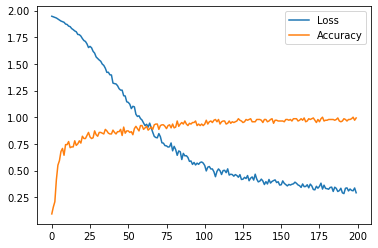

In [ ]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [ ]:
# evaluate the model on test set
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8140
